<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Predicting shots made per game by Kobe Bryant

---

In this lab you'll be using regularized regression penalties Ridge, Lasso, and Elastic Net to try and predict how many shots Kobe Bryant made per game in his career.

The Kobe shots dataset has hundreds of columns representing different characteristics of each basketball game. Fitting an ordinary linear regression using every predictor would dramatically overfit the model considering the limited number of observations (games) we have available. Furthermore, many of the predictors have significant multicollinearity. 


**Warning:** Some of these calculations are computationally expensive and may take a while to execute.  It may be worth while to only use a portion of the data to perform these calculations, especially if you have experienced kernel issues in the past.

---

### 1. Load packages and data

In [1]:
import numpy as np
import pandas as pd
import patsy

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
kobe = pd.read_csv('../../data/kobe_superwide_games.csv')

---

### 2. Examine the data

- How many columns are there?
- Examine what the observations (rows) and columns represent.
- Why is this data that regulari might be particularly useful for?

In [3]:
print('Columns:', len(kobe.columns))

Columns: 645


In [4]:
print(kobe.columns[0:20])

# The columns are various statistics for each game. 
# There is a column SHOTS_MADE that will be our target variable for prediction
# This is good for regulari because there are so many columns (feature selection)
# and many of the columns represent similar things (multicollinearity)

Index(['SHOTS_MADE', 'AWAY_GAME', 'SEASON_OPPONENT:atl:1996-97',
       'SEASON_OPPONENT:atl:1997-98', 'SEASON_OPPONENT:atl:1999-00',
       'SEASON_OPPONENT:atl:2000-01', 'SEASON_OPPONENT:atl:2001-02',
       'SEASON_OPPONENT:atl:2002-03', 'SEASON_OPPONENT:atl:2003-04',
       'SEASON_OPPONENT:atl:2004-05', 'SEASON_OPPONENT:atl:2005-06',
       'SEASON_OPPONENT:atl:2006-07', 'SEASON_OPPONENT:atl:2007-08',
       'SEASON_OPPONENT:atl:2008-09', 'SEASON_OPPONENT:atl:2009-10',
       'SEASON_OPPONENT:atl:2010-11', 'SEASON_OPPONENT:atl:2011-12',
       'SEASON_OPPONENT:atl:2012-13', 'SEASON_OPPONENT:atl:2013-14',
       'SEASON_OPPONENT:atl:2014-15'],
      dtype='object')


---

### 3. Make predictor and target variables. Standardize the predictors.

Why is normali necessary for regularized regressions?

Use the `sklearn.preprocessing` class `StandardScaler` to standardize the predictors.

In [5]:
y = kobe.SHOTS_MADE.values
X = kobe.iloc[:,1:]

# Initialize the StandardScaler object
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# use the "fit_transform" function to standardize the X design matrix
Xs = ss.fit_transform(X)

# Standardi is necessary for regularized regression because the beta
# values for each predictor variable must be on the same scale. If betas
# are different sizes just because of the scale of predictor variables
# the regulari term can't determine which betas are more/less 
# important based on their size.

---

### 4. Build a linear regression predicting `SHOTS_MADE` from the rest of the columns.

Cross-validate the $R^2$ of an ordinary linear regression model with 10 cross-validation folds.

How does it perform?

In [6]:
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, Xs, y, cv=10)

print(linreg_scores)
print(np.mean(linreg_scores))

[-6.63836860e+28 -5.76571443e+27 -2.51691682e+27 -3.53695145e+27
 -9.10563057e+27 -2.74285070e+27 -2.27121965e+27 -2.11009071e+27
 -1.42797198e+28 -1.34444023e+28]
-1.22157182436953e+28


In [7]:
# The mean R^2 is extremely negative. All the R^2 scores are negative in crossvalidation.
# The linear regression is performing far worse than baseline on the test sets.
# It is probably dramatically overfitting and the redundant variables are affecting
# the coefficients in weird ways.

---

### 5. Find an optimal value for Ridge regression alpha using `RidgeCV`.

[Go to the documentation and read how RidgeCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)

> *Hint: once the RidgeCV is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that Ridge performs best searching alphas through logarithmic space (`np.logspace`). This may take awhile to fit!


In [8]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs, y)

print(optimal_ridge.alpha_)

775.2597488629465


---

### 6. Cross-validate the Ridge regression $R^2$ with the optimal alpha.

Is it better than the Linear regression? If so, why might this be?

In [9]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs, y, cv=10)

print(ridge_scores)
print(np.mean(ridge_scores))

[0.5822626  0.52880462 0.4869004  0.59583817 0.52396335 0.52942952
 0.52842192 0.41153448 0.39857643 0.44489752]
0.5030628996817684


In [10]:
# It's vastly better than the Linear Regression. 
# There is likely so much multicollinearity in the data that "vanilla" regression
# overfits and has bogus coefficients on predictors. Ridge is 
# able to manage the multicollinearity and get a good out-of-sample result.

---

### 7. Find an optimal value for Lasso regression alpha using `LassoCV`.

[Go to the documentation and read how LassoCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) It is very similar to `RidgeCV`.

> *Hint: again, once the `LassoCV` is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that Lasso, unlike Ridge, performs best searching for alpha through linear space (`np.linspace`). However, you can actually let the LassoCV decide itself what alphas to use by instead setting the keyword argument `n_alphas=` to however many alphas you want it to search over. It is recommended to let sklearn choose the range of alphas.

_**Tip:** If you find your CV taking a long time and you're not sure if its working set `verbose =1`._

In [11]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs, y)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.06790539979326354


---

### 8. Cross-validate the Lasso $R^2$ with the optimal alpha.

Is it better than the Linear regression? Is it better than Ridge? What do the differences in results imply about the issues with the dataset?

In [12]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs, y, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[0.61603625 0.52641159 0.53888743 0.61322432 0.54627539 0.5554072
 0.52716822 0.44849563 0.4646267  0.51838952]
0.5354922262084527


In [13]:
# The lasso performs slightly better than the Ridge, but similarly.
# Lasso deals primarily with the feature selection of valuable variables,
# eliminating ones that are not useful. This also takes care of multicollinearity,
# but in a different way: it will choose the "best" of the correlated variables
# and zero-out the other redundant ones.
# There may also be useless variables in the data which it is simply getting rid
# of entirely.

---

### 9. Look at the coefficients for variables in the Lasso.

1. Show the coefficient for variables, ordered from largest to smallest coefficient by absolute value.
2. What percent of the variables in the original dataset are "zeroed-out" by the lasso?
3. What are the most important predictors for how many shots Kobe made in a game?

> **Note:** if you only fit the Lasso within `cross_val_score`, you will have to refit it outside of that
function to pull out the coefficients.

In [14]:
lasso.fit(Xs, y)

Lasso(alpha=0.06790539979326354)

In [15]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
579,COMBINED_SHOT_TYPE:jump_shot,1.233880,1.233880
574,SHOT_TYPE:2pt_field_goal,0.866201,0.866201
566,SHOT_ZONE_BASIC:restricted_area,0.453050,0.453050
577,COMBINED_SHOT_TYPE:dunk,0.274926,0.274926
611,ACTION_TYPE:jump_shot,-0.272130,0.272130
575,SHOT_TYPE:3pt_field_goal,0.140492,0.140492
582,SECONDS_REMAINING,0.132360,0.132360
612,ACTION_TYPE:layup_shot,-0.129658,0.129658
423,SEASON_OPPONENT:sac:1999-00,0.127065,0.127065
561,SHOT_ZONE_BASIC:above_the_break_3,0.118469,0.118469


In [16]:
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(X.shape[0]))

Percent variables zeroed out: 0.32605905006418484


---

### 10. Find an optimal value for Elastic Net regression alpha using `ElasticNetCV`.

[Go to the documentation and read how LassoCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html).

Note here that you will be optimizing both the alpha parameter and the l1_ratio:
- `alpha`: strength of regulari
- `l1_ratio`: amount of ridge vs. lasso (0 = all ridge, 1 = all lasso)
    
Do not include 0 in the search for `l1_ratio`: it will not allow it and break!

You can use `n_alphas` for the alpha parameters instead of setting your own values: highly recommended!

Also - be careful setting too many l1_ratios over cross-validation folds in your search. It can take a very long time if you choose too many combinations and for the most part there are diminishing returns in this data.

In [17]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
optimal_enet.fit(Xs, y)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

......................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.4min finished


0.07271360998818006
0.9587500000000001


---

### 11. Cross-validate the ElasticNet $R^2$ with the optimal alpha and l1_ratio.

How does it compare to the Ridge and Lasso regularized regressions?

In [18]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xs, y, cv=10)

print(enet_scores)
print(np.mean(enet_scores))

[0.61742795 0.52697978 0.53864379 0.61332045 0.54728018 0.55547707
 0.52548033 0.4485161  0.46407359 0.52059974]
0.5357798983416926


In [19]:
# Performs basically the same as lasso, which is to be expected given the
# l1_ration approaching 1 (full lasso).

---

### 12. [Bonus] Compare the residuals for the Ridge and Lasso visually.


In [20]:
# Need to fit the ElasticNet and Ridge outside of cross_val_score like i did with the ridge
ridge.fit(Xs, y)
lasso.fit(Xs, y)

Lasso(alpha=0.06790539979326354)

In [21]:
# model residuals:

ridge_resid = y - ridge.predict(Xs)
lasso_resid = y - lasso.predict(Xs)


/Users/ohalloranb/opt/anaconda3/envs/bayes/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


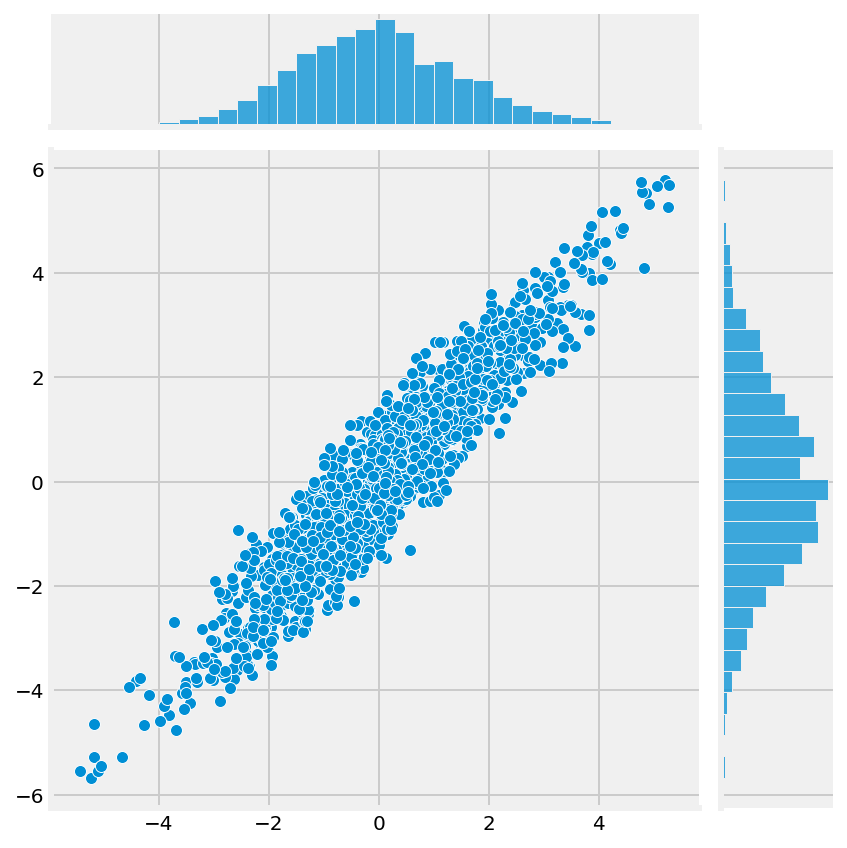

In [22]:
sns.jointplot(ridge_resid, lasso_resid)